# ME 5920 Homework 3 - Scientific Simulations Group 1

## Group Members


1.   George Ayobami Thomas
2.   Mridul Bhattarai
3.   Hossein Asgaribakhtiari

## Solution Steps

1. Data Loading:
Load the data provided in the Excel Sheets in DM (1).zip. Different Excel sheets represent the behavior of the material at different strain rates and temperatures. Each Excel sheet contains the data about the variation of stress with strain.

2. Data preprocessing: Preprocess the data and create a list of strain, strain-rate, temperature and stress.

3. Data split: Split the data pertaining into three parts (training, validation and testing). Also, use k-fold cross validation strategy for training.

4. Naive Learning: Use the strain, strain rate and temperature at every point to predict the flow stress. A naive neural
network(fully connected deep neural network) is idea here.

5. LSTMs: build a LSTM network to predict flow stress for a given strain, strain-rate and temperature. Do a study on the parameter study on the roll-out of the LSTM required.

6. Deployment: The true stress and true strain results are obtained for a sheet metal. Tensile testing is performed on a small rectangular strip, 6cm in length and the jaws holding one end of the specimen and the other side is pulled by a displacement of x. For all the experiments in the data, displacement is such a way that the strain rate is constant through out the process. However, in forming, strain rate varies
non-linearly. Example: displacement could be represented as x = t3 2t2 + t. Predict the stress-strain curve for this profile of displacements.

7. Presenting results: Compare the results you obtain for training, validation and testing data on the naive learning model and the LSTM. Visualize the stress-strain curves of the predicted (both) and the actual. Also, visualize the stress-strain curve for the deployment for both the learning cases.

## Importing necessary packages

In [ ]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Subset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
home_dir = '/content/drive/MyDrive/CPS/DM-2'
os.chdir(home_dir)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Preparing Data


In [ ]:
# Metric functions
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Data Preprocessing
def data_preprocess():
    data_dir = '/content/drive/MyDrive/CPS/DM-2'

    temp = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650]
    strain_rates = [0.1, 0.01, 0.001, 0.0001]
    train_val_list = []
    test_list = []
    all_data = []

    for t in temp:
        temp_folder = f"{t}C"
        temp_path = os.path.join(data_dir, temp_folder)

        if not os.path.isdir(temp_path):
            print(f"Folder {temp_folder} does not exist\n")
            continue

        for s in strain_rates:
            strain_file_name = f"{t}-{s}.xls"
            file_path = os.path.join(temp_path, strain_file_name)

            if not os.path.isfile(file_path):
                print(f"File {strain_file_name} does not exist.")
                continue

            try:
                df = pd.read_excel(file_path)
                df.columns = df.columns.str.strip().str.lower()
                df = df.loc[:, ~df.columns.duplicated()]

                displacement_col = df.columns[0] # 1st column (index starts at 0)
                load_col = df.columns[1]         # 2nd column
                true_stress_col = df.columns[7]  # 8th column
                true_strain_col = df.columns[6]  # 7th column

                df[displacement_col] = pd.to_numeric(df[displacement_col], errors='coerce')
                df[load_col] = pd.to_numeric(df[load_col], errors='coerce')
                df[true_stress_col] = pd.to_numeric(df[true_stress_col], errors='coerce')
                df[true_strain_col] = pd.to_numeric(df[true_strain_col], errors='coerce')

                df = df[(df[true_stress_col].notna()) & (df[true_stress_col] != 0) &
                        (df[true_strain_col].notna()) & (df[true_strain_col] != 0) &
                        (df[load_col].notna()) & (df[load_col] != 0)]

                temp_df = pd.DataFrame({
                    'Temperature (C)': t,
                    'Strain Rate': s,
                    'Displacement': df[displacement_col],
                    'Load': df[load_col],
                    'True Stress': df[true_stress_col],
                    'True Strain': df[true_strain_col]
                })

                all_data.append(temp_df)

                train_df, test_df = train_test_split(temp_df, test_size=0.2, random_state=42)
                train_val_list.append(train_df)
                test_list.append(test_df)

            except Exception as e:
                print(f"Failed to process {file_path}: {e}")

    train_val_df = pd.concat(train_val_list, ignore_index=True)
    test_df = pd.concat(test_list, ignore_index=True)
    final_df = pd.concat(all_data, ignore_index=True)

    return final_df, train_val_df, test_df




### Creating K-Folds

In [ ]:
# Function to prepare data loaders with k-fold cross-validation
def prepare_dataloaders_with_kfold(X_tensor, y_tensor, k=4):
    dataset = TensorDataset(X_tensor, y_tensor) # Using the original sequential dataset
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    folds = []

    indices = list(range(len(dataset)))
    for train_idx, val_idx in kfold.split(indices):
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32)
        val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=32)

        folds.append((train_loader, val_loader))

    return folds

### Generating Sequences for LSTM

In [ ]:
# Function to create sequences using a sliding window
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        seq = X[i : i + sequence_length]
        label = y[i + sequence_length]
        X_seq.append(seq)
        y_seq.append(label)
    return np.array(X_seq), np.array(y_seq)

### Scale and Prepare Data

In [ ]:
# Update scale and prepare data function for sequences
def scale_and_prepare_data():

    sequence_length=10
    # Get raw data
    final_data, train_data, test_data = data_preprocess()

    # Extract train data
    combined_df = train_data[['Temperature (C)', 'Strain Rate', 'True Strain', 'True Stress']]

    # Extract test data
    combined_df_test = test_data[['Temperature (C)', 'Strain Rate', 'True Strain', 'True Stress']]


    #-------------Fully Connected------------------------#

    #TRAIN

    # Separate features and target
    features = combined_df[['Temperature (C)', 'Strain Rate', 'True Strain']]
    target = combined_df['True Stress']

    X_train = features.values
    y_train = target.values

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.reshape(-1, 1))

    # Convert to torch tensors for FC
    X_train_tensor_fc = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor_fc = torch.tensor(y_train, dtype=torch.float32)
    train_dataset_fc = TensorDataset(X_train_tensor_fc, y_train_tensor_fc)

    # TEST

    # Process test data similarly
    features_test = combined_df_test[['Temperature (C)','Strain Rate', 'True Strain']]
    target_test = combined_df_test['True Stress']

    X_test = features_test.values
    y_test = target_test.values

    X_test = scaler.transform(X_test)
    y_test = target_scaler.transform(y_test.reshape(-1, 1))

    # Convert to torch tensors for FC
    X_test_tensor_fc = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor_fc = torch.tensor(y_test, dtype=torch.float32)
    test_dataset_fc = TensorDataset(X_test_tensor_fc, y_test_tensor_fc)



    #--------------LSTM-----------------------------------#

    # TRAIN

    combined_df_lstm = combined_df.sort_values(by=['Temperature (C)', 'Strain Rate', 'True Strain']).reset_index(drop=True)

    features_lstm = combined_df_lstm[['Temperature (C)', 'Strain Rate', 'True Strain']]
    target_lstm = combined_df_lstm['True Stress']

    X_train_lstm = features_lstm.values
    y_train_lstm = target_lstm.values

    scaler = StandardScaler()
    X_train_lstm = scaler.fit_transform(X_train_lstm)

    target_scaler = StandardScaler()
    y_train_lstm = target_scaler.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()

    # Create sequences from training data using a sliding window approach
    X_train_seq, y_train_seq = create_sequences(X_train_lstm, y_train_lstm, sequence_length)

    # Convert to torch tensors for LSTM
    X_train_tensor_lstm = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_tensor_lstm = torch.tensor(y_train_seq, dtype=torch.float32)
    train_dataset_lstm = TensorDataset(X_train_tensor_lstm, y_train_tensor_lstm)


    # TEST

    # Extract and sort training data by Temperature, Strain Rate, and Plastic Strain

    combined_df_lstm_test = combined_df_test.sort_values(by=['Temperature (C)', 'Strain Rate', 'True Strain']).reset_index(drop=True)

    # Process test data similarly
    features_test_lstm = combined_df_lstm_test[['Temperature (C)','Strain Rate', 'True Strain']]
    target_test_lstm = combined_df_lstm_test['True Stress']

    X_test_lstm = features_test_lstm.values
    y_test_lstm = target_test_lstm.values

    X_test_lstm = scaler.transform(X_test_lstm)
    y_test_lstm = target_scaler.transform(y_test_lstm.reshape(-1, 1)).flatten()

    # Creating Sequences for test data

    X_test_seq, y_test_seq = create_sequences(X_test_lstm, y_test_lstm, sequence_length)

    # Convert to Tensor

    X_test_tensor_lstm = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test_tensor_lstm = torch.tensor(y_test_seq, dtype=torch.float32)
    test_dataset_lstm = TensorDataset(X_test_tensor_lstm, y_test_tensor_lstm)

    '''folds = prepare_dataloaders_with_kfold(train_dataset_lstm, test_dataset_lstm, k=5)

    print(f"\nTotal Folds: {len(folds)}")
    for i, (train_loader, val_loader) in enumerate(folds):
        print(f"Fold {i + 1} - TrainLoader size: {len(train_loader.dataset)}, ValLoader size: {len(val_loader.dataset)}")'''

    return final_data, train_dataset_fc, test_dataset_fc, train_dataset_lstm, test_dataset_lstm, scaler, target_scaler

## Fully Connected Neural Network

In [ ]:
import torch.nn as nn

class NaiveNN(nn.Module):
    def __init__(self, input_dim):
        super(NaiveNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)


### Train the FC

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X_val, y_val in val_loader:
                val_pred = model(X_val)
                val_loss = criterion(val_pred, y_val)
                val_losses.append(val_loss.item())
            avg_val_loss = np.mean(val_losses)
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}")

###TESTING

In [ ]:
def evaluate_model(model, test_loader, scaler, target_scaler):
    model.eval()
    true_stress = []
    predicted_stress = []

    temperature = []
    strain_rate = []
    strain = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)

            true_stress.extend(y_batch.numpy())
            predicted_stress.extend(y_pred.numpy())

            temperature.extend(X_batch[:, 0].numpy())     # Temperature Values
            strain_rate.extend(X_batch[:, 1].numpy())     # Strain Rate Values
            strain.extend(X_batch[:, 2].numpy())          # Strain Values

    true_stress = np.array(true_stress)
    predicted_stress = np.array(predicted_stress)

    # Convert to numpy arrays
    temperatures = np.array(temperature)
    strain_rates = np.array(strain_rate)
    strains = np.array(strain)

    # Standardized metrics
    mae = mean_absolute_error(true_stress, predicted_stress)
    rmse = np.sqrt(root_mean_squared_error(true_stress, predicted_stress))
    print(f"\nTest MAE (standardized): {mae:.6f}")
    print(f"Test RMSE (standardized): {rmse:.6f}")

    # Plotting standardized
    plt.figure(figsize=(8, 6))
    plt.scatter(true_stress, predicted_stress, s=1)
    plt.plot([true_stress.min(), true_stress.max()],
             [true_stress.min(), true_stress.max()],
             'r--', label='Ideal: y=x')
    plt.xlabel("True Stress (Standardized)")
    plt.ylabel("Predicted Stress (Standardized)")
    plt.title("Naive NN - True vs Predicted Stress (Standardized)")
    plt.legend()
    plt.grid(True)
    plt.show()



    # Inverse transform
    features_original = scaler.inverse_transform(np.stack((temperatures, strain_rates, strains), axis=1))
    temp_orig = features_original[:, 0]
    rate_orig = features_original[:, 1]
    strain_orig = features_original[:, 2]

    true_actual = target_scaler.inverse_transform(true_stress.reshape(-1, 1)).flatten()
    pred_actual = target_scaler.inverse_transform(predicted_stress.reshape(-1, 1)).flatten()

     # Plotting True vs Predicted Stress (Actual)
    plt.figure(figsize=(6, 6))
    plt.scatter(true_actual, pred_actual, s=1)
    plt.plot([true_actual.min(), true_actual.max()],
             [true_actual.min(), true_actual.max()],
             'r--', label='Ideal: y=x')
    plt.xlabel("True Stress (Actual)")
    plt.ylabel("Predicted Stress (Actual)")
    plt.title("Naive NN - True vs Predicted Stress (Actual Scale)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Filtering conditions (Using np.round because after inverse transform we found that the temperature values were not excat)
    condition_1 = (np.round(temp_orig) == 50.0) & (np.round(rate_orig, 2) == 0.01)
    condition_2 = (np.round(temp_orig) == 50.0) & (np.round(rate_orig, 3) == 0.001)
    condition_3 = (np.round(temp_orig) == 150.0) & (np.round(rate_orig, 2) == 0.01)
    condition_4 = (np.round(temp_orig) == 150.0) & (np.round(rate_orig, 4) == 0.0001)
    condition_5 = (np.round(temp_orig) == 550.0) & (np.round(rate_orig, 3) == 0.001)
    condition_6 = (np.round(temp_orig) == 550.0) & (np.round(rate_orig, 4) == 0.0001)
    condition_7 = (np.round(temp_orig) == 650.0) & (np.round(rate_orig, 2) == 0.01)
    condition_8 = (np.round(temp_orig) == 650.0) & (np.round(rate_orig, 3) == 0.001)

    '''----------------------------------------------------------------------------------

    ----------------------------------------------------------------------------------'''

    #First Plot for temperature values: 50 (0.01 and 0.001), and 150 (0.01 and 0.0001)
    # Plotting True Stress vs True Strain
    plt.figure(figsize=(8, 6))

    # For each condition, sort the strain values and then apply the sorted indices
    strain_sorted_1 = np.argsort(strain_orig[condition_1])
    strain_sorted_2 = np.argsort(strain_orig[condition_2])
    strain_sorted_3 = np.argsort(strain_orig[condition_3])
    strain_sorted_4 = np.argsort(strain_orig[condition_4])
    strain_sorted_5 = np.argsort(strain_orig[condition_5])
    strain_sorted_6 = np.argsort(strain_orig[condition_6])
    strain_sorted_7 = np.argsort(strain_orig[condition_7])
    strain_sorted_8 = np.argsort(strain_orig[condition_8])

    # Plotting true stress versus true strain as well as predicted stress versus true strain curves for some temperature and strain rate pairs
    plt.plot(
        strain_orig[condition_1][strain_sorted_1],
        true_actual[condition_1][strain_sorted_1],
        'b-', label='Actual: 50°C, 0.01 /s'
    )
    plt.plot(
        strain_orig[condition_1][strain_sorted_1],
        pred_actual[condition_1][strain_sorted_1],
        'b:', label='Predicted: 50°C, 0.01 /s'
    )

    plt.plot(
        strain_orig[condition_2][strain_sorted_2],
        true_actual[condition_2][strain_sorted_2],
        'g-', label='Actual: 50°C, 0.001 /s'
    )
    plt.plot(
        strain_orig[condition_2][strain_sorted_2],
        pred_actual[condition_2][strain_sorted_2],
        'g:', label='Predicted: 50°C, 0.001 /s'
    )

    plt.plot(
        strain_orig[condition_3][strain_sorted_3],
        true_actual[condition_3][strain_sorted_3],
        'r-', label='Actual: 150°C, 0.01 /s'
    )
    plt.plot(
        strain_orig[condition_3][strain_sorted_3],
        pred_actual[condition_3][strain_sorted_3],
        'r:', label='Actual: 150°C, 0.01 /s'
    )

    plt.plot(
        strain_orig[condition_4][strain_sorted_4],
        true_actual[condition_4][strain_sorted_4],
        'm-', label='Actual: 150°C, 0.0001 /s'
    )
    plt.plot(
        strain_orig[condition_4][strain_sorted_4],
        pred_actual[condition_4][strain_sorted_4],
        'm:', label='Actual: 150°C, 0.0001 /s'
    )

    plt.xlabel("True Strain")
    plt.ylabel("True Stress (Actual)")
    plt.title("Stress-Strain Curves (Actual and Predicted)-Group 1(Using Naive NN)")
    plt.legend()
    plt.grid(True)
    plt.show()

    '''----------------------------------------------------------------------------------

    ----------------------------------------------------------------------------------'''





    #Second Plot for temperature values: 550 (0.001 and 0.0001), and 650 (0.01 and 0.001)
    # Plotting True Stress vs True Strain
    plt.figure(figsize=(8, 6))

    # Plotting true stress versus true strain as well as predicted stress versus true strain curves for some temperature and strain rate pairs
    plt.plot(
        strain_orig[condition_5][strain_sorted_5],
        true_actual[condition_5][strain_sorted_5],
        'b-', label='Actual: 550°C, 0.001 /s'
    )
    plt.plot(
        strain_orig[condition_5][strain_sorted_5],
        pred_actual[condition_5][strain_sorted_5],
        'b:', label='Predicted: 550°C, 0.001 /s'
    )

    plt.plot(
        strain_orig[condition_6][strain_sorted_6],
        true_actual[condition_6][strain_sorted_6],
        'g-', label='Actual: 550°C, 0.0001 /s'
    )
    plt.plot(
        strain_orig[condition_6][strain_sorted_6],
        pred_actual[condition_6][strain_sorted_6],
        'g:', label='Predicted: 550°C, 0.0001 /s'
    )

    plt.plot(
        strain_orig[condition_7][strain_sorted_7],
        true_actual[condition_7][strain_sorted_7],
        'r-', label='Actual: 650°C, 0.01 /s'
    )
    plt.plot(
        strain_orig[condition_7][strain_sorted_7],
        pred_actual[condition_7][strain_sorted_7],
        'r:', label='Actual: 650°C, 0.01 /s'
    )

    plt.plot(
        strain_orig[condition_8][strain_sorted_8],
        true_actual[condition_8][strain_sorted_8],
        'm-', label='Actual: 650°C, 0.001 /s'
    )
    plt.plot(
        strain_orig[condition_8][strain_sorted_8],
        pred_actual[condition_8][strain_sorted_8],
        'm:', label='Actual: 650°C, 0.001 /s'
    )

    plt.xlabel("True Strain")
    plt.ylabel("True Stress (Actual)")
    plt.title("Stress-Strain Curves (Actual and Predicted)-Group 2(Using Naive NN)")
    plt.legend()
    plt.grid(True)
    plt.show()



###Deployment of FC

In [ ]:
def deployment_fc(model, scaler, target_scaler):
    temperature_values = [25, 50, 150, 250, 550, 650]
    L0 = 6  # Gauge length in cm

    # Time vector from 0 to 5 seconds with 1000 samples
    t = np.linspace(0, 1.5, 2000)

    # Displacement as a function of time
    x_t = (t**3 + 2 * t**2 + t)

    # Compute engineering strain: displacement / gauge length
    eng_strain = x_t / L0

    # Compute true strain from engineering strain
    true_strain = np.log(1 + eng_strain)

    # Compute the rate of displacement (velocity)
    dx_dt = np.gradient(x_t, t)

    # Compute engineering strain rate
    #strain_rate = dx_dt / L0
    strain_rate=0.001
    # Create plot
    plt.figure(figsize=(8, 6))

    for temperature in temperature_values:
        features = np.column_stack([
            np.full_like(true_strain, temperature),
            np.full_like(true_strain, strain_rate),
            true_strain
        ])

        #scaler from training
        features_scaled = scaler.transform(features)

        # Convert to tensor
        features_scaled_tensor = torch.tensor(features_scaled, dtype=torch.float32)

        # Predict stress
        model.eval()
        with torch.no_grad():
            predicted_stress = model(features_scaled_tensor).squeeze().cpu().numpy()

        # Inverse transform using trained target scaler
        predicted_stress = target_scaler.inverse_transform(predicted_stress.reshape(-1, 1))

        # Plot
        plt.plot(true_strain, predicted_stress, label=f'Temperature {temperature}°C')

    plt.xlabel("True Strain")
    plt.ylabel("Predicted Stress (MPa)")
    plt.title("Stress–Strain Curves Predicted by Model for Different Temperatures")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


###MAIN FC

In [ ]:
# seq_length = 50
final_data, train_dataset_fc, test_dataset_fc, train_dataset_lstm, test_dataset_lstm, scaler, target_scaler = scale_and_prepare_data()


X_train_fc = train_dataset_fc.tensors[0]
y_train_fc = train_dataset_fc.tensors[1]

folds = prepare_dataloaders_with_kfold(X_train_fc, y_train_fc, k=4)

Folder 400C does not exist

File 450-0.1.xls does not exist.
File 500-0.1.xls does not exist.
File 500-0.001.xls does not exist.
File 550-0.1.xls does not exist.
File 600-0.1.xls does not exist.
File 650-0.1.xls does not exist.


In [ ]:

# input_size = 3
# hidden_size = 64

model = NaiveNN(3)

for i, (train_loader, val_loader) in enumerate(folds):
    print(f"\nTraining Fold {i+1}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)
torch.save(model.state_dict(), "/content/drive/MyDrive/CPS/DM-2/naive_model_trained.pth")


Training Fold 1
Epoch 1/20, Val Loss: 0.0257
Epoch 2/20, Val Loss: 0.0130
Epoch 3/20, Val Loss: 0.0102
Epoch 4/20, Val Loss: 0.0077
Epoch 5/20, Val Loss: 0.0059
Epoch 6/20, Val Loss: 0.0065
Epoch 7/20, Val Loss: 0.0059
Epoch 8/20, Val Loss: 0.0045
Epoch 9/20, Val Loss: 0.0043
Epoch 10/20, Val Loss: 0.0046
Epoch 11/20, Val Loss: 0.0038
Epoch 12/20, Val Loss: 0.0041
Epoch 13/20, Val Loss: 0.0041
Epoch 14/20, Val Loss: 0.0052
Epoch 15/20, Val Loss: 0.0051
Epoch 16/20, Val Loss: 0.0064
Epoch 17/20, Val Loss: 0.0039
Epoch 18/20, Val Loss: 0.0048
Epoch 19/20, Val Loss: 0.0034
Epoch 20/20, Val Loss: 0.0036

Training Fold 2
Epoch 1/20, Val Loss: 0.0037
Epoch 2/20, Val Loss: 0.0023
Epoch 3/20, Val Loss: 0.0036
Epoch 4/20, Val Loss: 0.0034
Epoch 5/20, Val Loss: 0.0032
Epoch 6/20, Val Loss: 0.0024
Epoch 7/20, Val Loss: 0.0027
Epoch 8/20, Val Loss: 0.0024
Epoch 9/20, Val Loss: 0.0046
Epoch 10/20, Val Loss: 0.0031
Epoch 11/20, Val Loss: 0.0032
Epoch 12/20, Val Loss: 0.0033
Epoch 13/20, Val Loss: 0


Test MAE (standardized): 0.022014
Test RMSE (standardized): 0.206223


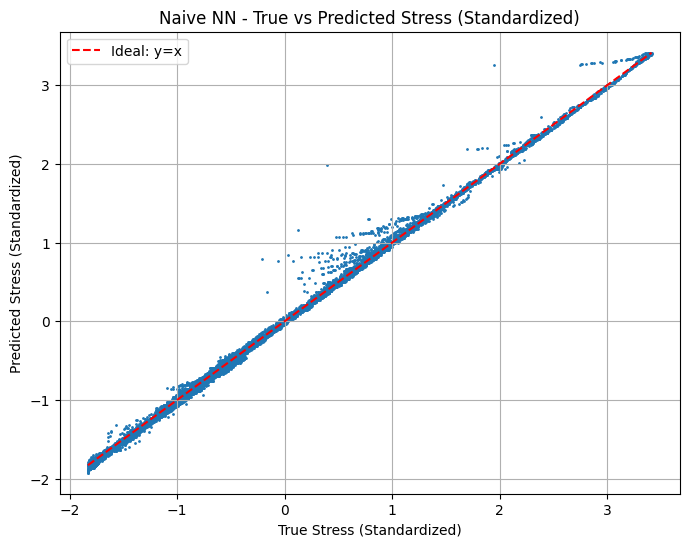

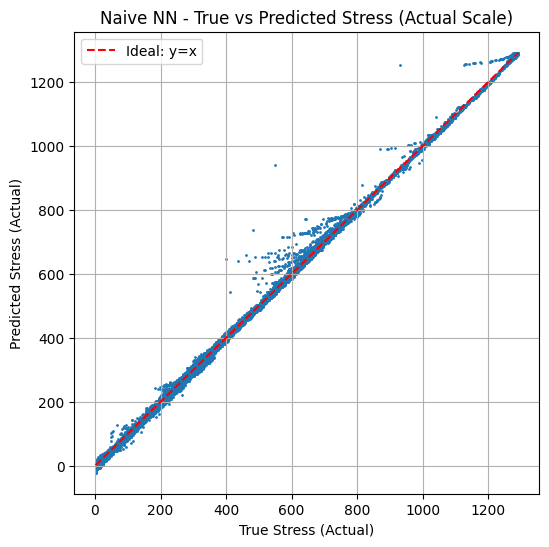

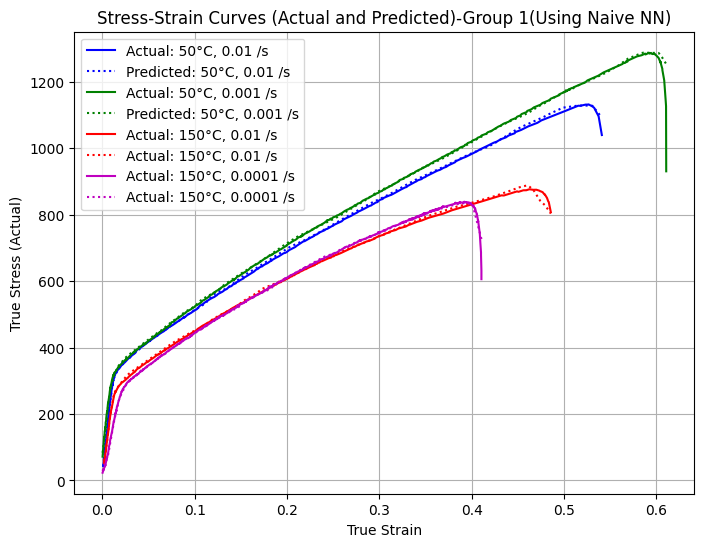

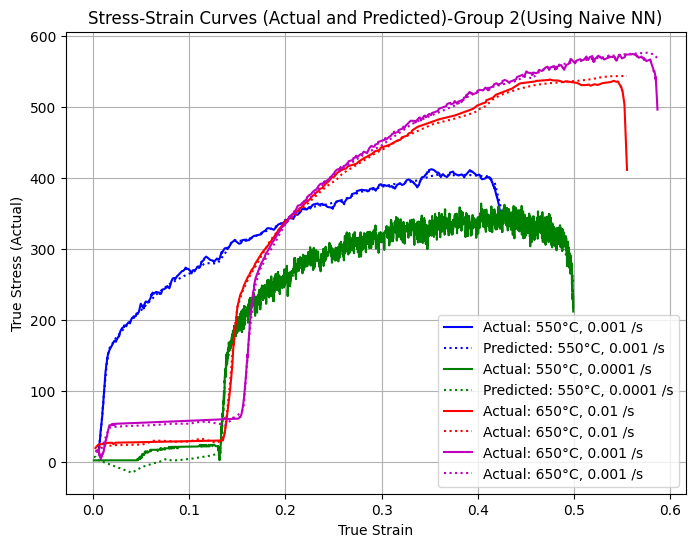

In [ ]:
# Create a model instance
eval_model = NaiveNN(input_dim=3)

# Load the trained weights into this model
eval_model.load_state_dict(torch.load("/content/drive/MyDrive/CPS/DM-2/naive_model_trained.pth"))

# Set the model to evaluation mode
eval_model.eval()

# Use the test loader to evaluate the model
test_loader = DataLoader(test_dataset_fc, shuffle=True)
evaluate_model(eval_model, test_loader, scaler, target_scaler)


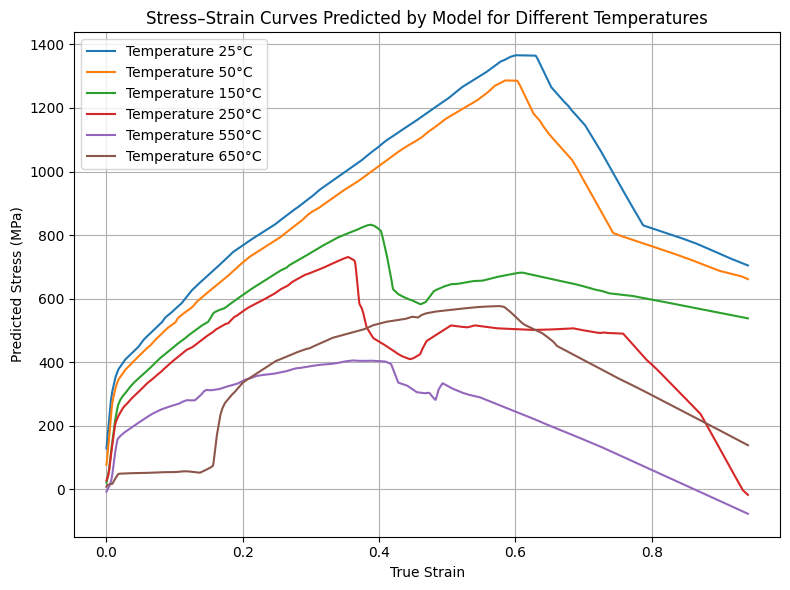

In [ ]:
deployment_fc(eval_model, scaler, target_scaler)

### 5.1 Run Data Preparation

### 5.2 Building the LSTM regressor

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out: [batch, seq, hidden]
        out = self.fc(lstm_out[:, -1, :])  # Using the output from last t step
        return out.squeeze()


### 5.3 Building the Training Passes

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_losses = []
            for X_val, y_val in val_loader:
                val_pred = model(X_val)
                val_loss = criterion(val_pred, y_val)
                val_losses.append(val_loss.item())
            avg_val_loss = np.mean(val_losses)
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {avg_val_loss:.4f}")


### 5.4 Building the LSTM data loaders with KFold

In [ ]:
def prepare_dataloaders_with_kfold(X_tensor, y_tensor, k=4):
    dataset = TensorDataset(X_tensor, y_tensor) # Using the original sequential dataset
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    folds = []

    indices = list(range(len(dataset)))
    for train_idx, val_idx in kfold.split(indices):
        train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32)
        val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=32)

        folds.append((train_loader, val_loader))

    return folds

### Main Function for LSTM

In [ ]:
seq_length = 50

X_train = train_dataset_lstm.tensors[0]
y_train = train_dataset_lstm.tensors[1]

folds = prepare_dataloaders_with_kfold(X_train, y_train, k=4)

input_size = 3
hidden_size = 64

model = LSTMRegressor(input_size, hidden_size)

for i, (train_loader, val_loader) in enumerate(folds):
    print(f"\nTraining Fold {i+1}")
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20)



Training Fold 1
Epoch 1/20, Val Loss: 0.0433
Epoch 2/20, Val Loss: 0.0243
Epoch 3/20, Val Loss: 0.0169
Epoch 4/20, Val Loss: 0.0116
Epoch 5/20, Val Loss: 0.0103
Epoch 6/20, Val Loss: 0.0100
Epoch 7/20, Val Loss: 0.0112
Epoch 8/20, Val Loss: 0.0085
Epoch 9/20, Val Loss: 0.0094
Epoch 10/20, Val Loss: 0.0083
Epoch 11/20, Val Loss: 0.0070
Epoch 12/20, Val Loss: 0.0065
Epoch 13/20, Val Loss: 0.0088
Epoch 14/20, Val Loss: 0.0064
Epoch 15/20, Val Loss: 0.0072
Epoch 16/20, Val Loss: 0.0063
Epoch 17/20, Val Loss: 0.0063
Epoch 18/20, Val Loss: 0.0077
Epoch 19/20, Val Loss: 0.0102
Epoch 20/20, Val Loss: 0.0078

Training Fold 2
Epoch 1/20, Val Loss: 0.0074
Epoch 2/20, Val Loss: 0.0064
Epoch 3/20, Val Loss: 0.0062
Epoch 4/20, Val Loss: 0.0070
Epoch 5/20, Val Loss: 0.0059
Epoch 6/20, Val Loss: 0.0062
Epoch 7/20, Val Loss: 0.0075
Epoch 8/20, Val Loss: 0.0061
Epoch 9/20, Val Loss: 0.0062
Epoch 10/20, Val Loss: 0.0084
Epoch 11/20, Val Loss: 0.0067
Epoch 12/20, Val Loss: 0.0062
Epoch 13/20, Val Loss: 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Val Loss: 0.0046
Epoch 2/20, Val Loss: 0.0051
Epoch 3/20, Val Loss: 0.0046
Epoch 4/20, Val Loss: 0.0048
Epoch 5/20, Val Loss: 0.0045
Epoch 6/20, Val Loss: 0.0075
Epoch 7/20, Val Loss: 0.0046
Epoch 8/20, Val Loss: 0.0041
Epoch 9/20, Val Loss: 0.0050
Epoch 10/20, Val Loss: 0.0049
Epoch 11/20, Val Loss: 0.0048
Epoch 12/20, Val Loss: 0.0044
Epoch 13/20, Val Loss: 0.0043
Epoch 14/20, Val Loss: 0.0056
Epoch 15/20, Val Loss: 0.0044
Epoch 16/20, Val Loss: 0.0046
Epoch 17/20, Val Loss: 0.0037
Epoch 18/20, Val Loss: 0.0042
Epoch 19/20, Val Loss: 0.0048
Epoch 20/20, Val Loss: 0.0043


### 5.5 Save the Model Weights

In [ ]:
torch.save(model.state_dict(), 'lstm_model_weights.pth')

### 5.6 Evaluate and Plot

In [ ]:
def prepare_test_sequence_loader(X_test_tensor, y_test_tensor, seq_length):

    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=True)
    return test_loader

In [ ]:
def evaluate_lstm(model, test_loader, scaler, target_scaler):
    model.eval()
    true_stress = []
    predicted_stress = []

    temperature = []
    strain_rate = []
    strain = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)

            true_stress.extend(y_batch.numpy())
            predicted_stress.extend(y_pred.numpy())

            # Extract the last time-step features: (batch, seq_len, 3) → (batch, 3)
            last_step = X_batch[:, -1, :]  # Assumes [T, R, E] ordering

            temperature.extend(last_step[:, 0].numpy())     # Temperature Values
            strain_rate.extend(last_step[:, 1].numpy())     # Strain Rate Values
            strain.extend(last_step[:, 2].numpy())          # Strain Values

    true_stress = np.array(true_stress)
    predicted_stress = np.array(predicted_stress)

    mae = mean_absolute_error(true_stress, predicted_stress)
    rmse = np.sqrt(mean_squared_error(true_stress, predicted_stress))
    print(f"\nTest MAE (standardized): {mae:.6f}")
    print(f"Test RMSE (standardized): {rmse:.6f}")

    # Plotting standardized predictions
    plt.figure(figsize=(6, 6))
    plt.scatter(true_stress, predicted_stress, s=1)
    plt.plot([true_stress.min(), true_stress.max()],
             [true_stress.min(), true_stress.max()],
             'r--', label='Ideal: y=x')
    plt.xlabel("True Stress (Standardized)")
    plt.ylabel("Predicted Stress (Standardized)")
    plt.title("LSTM - True vs Predicted Stress (Standardized)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Inverse transform features and target
    features_original = scaler.inverse_transform(np.stack((temperature, strain_rate, strain), axis=1))
    temp_orig = features_original[:, 0]
    rate_orig = features_original[:, 1]
    strain_orig = features_original[:, 2]

    true_actual = target_scaler.inverse_transform(true_stress.reshape(-1, 1)).flatten()
    pred_actual = target_scaler.inverse_transform(predicted_stress.reshape(-1, 1)).flatten()

    # Plotting Actual Scale
    plt.figure(figsize=(6, 6))
    plt.scatter(true_actual, pred_actual, s=1)
    plt.plot([true_actual.min(), true_actual.max()],
             [true_actual.min(), true_actual.max()],
             'r--', label='Ideal: y=x')
    plt.xlabel("True Stress (Actual)")
    plt.ylabel("Predicted Stress (Actual)")
    plt.title("LSTM - True vs Predicted Stress (Actual Scale)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Define filter conditions
    condition_1 = (np.round(temp_orig) == 50.0) & (np.round(rate_orig, 2) == 0.01)
    condition_2 = (np.round(temp_orig) == 50.0) & (np.round(rate_orig, 3) == 0.001)
    condition_3 = (np.round(temp_orig) == 150.0) & (np.round(rate_orig, 2) == 0.01)
    condition_4 = (np.round(temp_orig) == 150.0) & (np.round(rate_orig, 4) == 0.0001)
    condition_5 = (np.round(temp_orig) == 550.0) & (np.round(rate_orig, 3) == 0.001)
    condition_6 = (np.round(temp_orig) == 550.0) & (np.round(rate_orig, 4) == 0.0001)
    condition_7 = (np.round(temp_orig) == 650.0) & (np.round(rate_orig, 2) == 0.01)
    condition_8 = (np.round(temp_orig) == 650.0) & (np.round(rate_orig, 3) == 0.001)

    # Sorted indices for each condition
    sort_idx = lambda cond: np.argsort(strain_orig[cond])

    # First subplot (50°C, 150°C)
    plt.figure(figsize=(8, 6))
    for cond, color, label in zip(
        [condition_1, condition_2, condition_3, condition_4],
        ['b', 'g', 'r', 'm'],
        ['50°C, 0.01/s', '50°C, 0.001/s', '150°C, 0.01/s', '150°C, 0.0001/s']
    ):
        idx = sort_idx(cond)
        plt.plot(strain_orig[cond][idx], true_actual[cond][idx], color + '-', label=f"Actual: {label}")
        plt.plot(strain_orig[cond][idx], pred_actual[cond][idx], color + ':', label=f"Predicted: {label}")

    plt.xlabel("True Strain")
    plt.ylabel("True Stress (Actual)")
    plt.title("Stress-Strain Curves (Actual and Predicted) - Group 1 (Using LSTM)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Second subplot (550°C, 650°C)
    plt.figure(figsize=(8, 6))
    for cond, color, label in zip(
        [condition_5, condition_6, condition_7, condition_8],
        ['b', 'g', 'r', 'm'],
        ['550°C, 0.001/s', '550°C, 0.0001/s', '650°C, 0.01/s', '650°C, 0.001/s']
    ):
        idx = sort_idx(cond)
        plt.plot(strain_orig[cond][idx], true_actual[cond][idx], color + '-', label=f"Actual: {label}")
        plt.plot(strain_orig[cond][idx], pred_actual[cond][idx], color + ':', label=f"Predicted: {label}")

    plt.xlabel("True Strain")
    plt.ylabel("True Stress (Actual)")
    plt.title("Stress-Strain Curves (Actual and Predicted) - Group 2 (Using LSTM)")
    plt.legend()
    plt.grid(True)
    plt.show()



Test MAE (standardized): 0.033791
Test RMSE (standardized): 0.131262


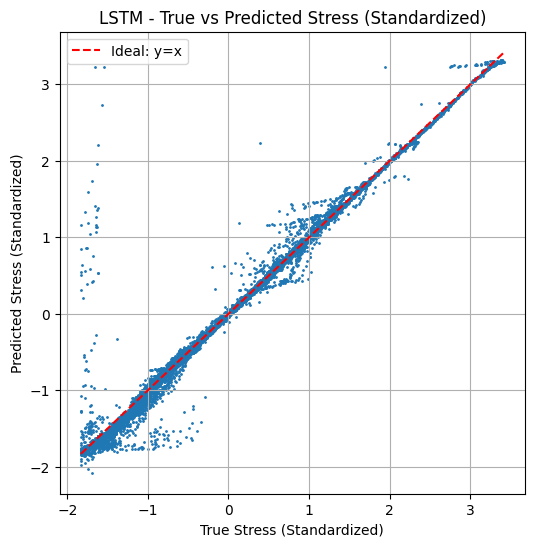

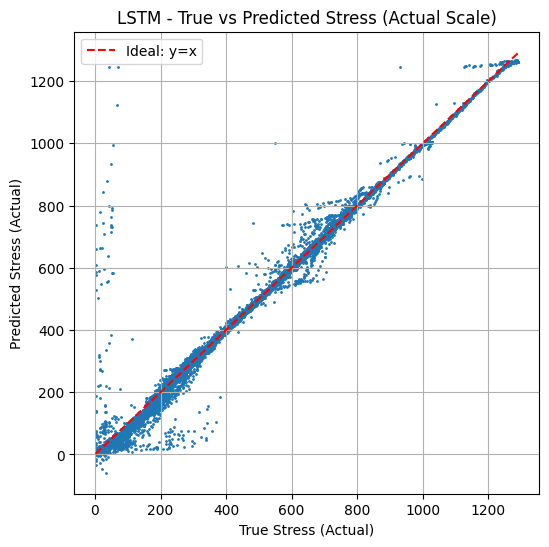

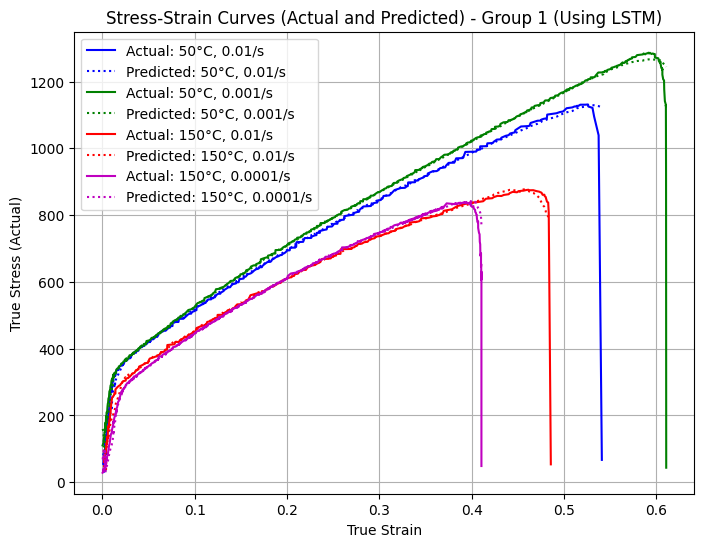

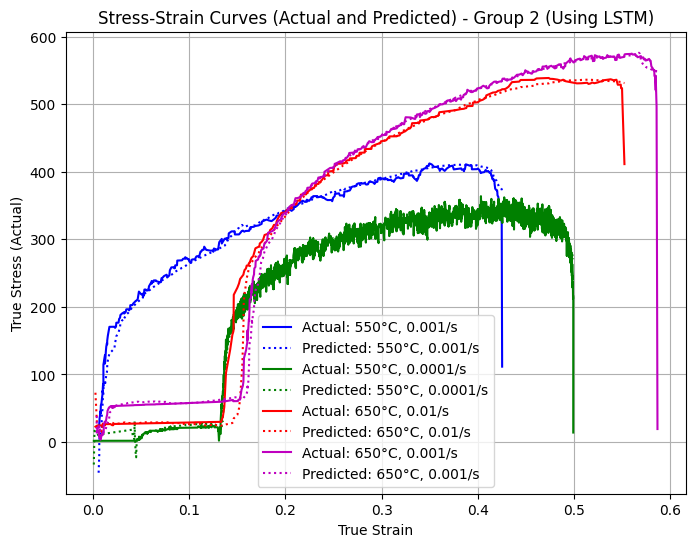

In [ ]:
# Creating the test loader
X_test = test_dataset_lstm.tensors[0]
y_test = test_dataset_lstm.tensors[1]
test_loader = prepare_test_sequence_loader(X_test, y_test, seq_length=50)

# Load the saved weights
model.load_state_dict(torch.load('lstm_model_weights.pth'))

# Evluate the LSTM
evaluate_lstm(model, test_loader, scaler, target_scaler)


### 5.6 Parameter Study

For the LSTM, Different parameters were applied with the aim of reducing the losses and correctly predicting the stresses.

The chart above shows the relationship between the true stresses and the predicted stresses. The red dashed line shows a perfect relationship where the predicted stress is equal to the true stress, but since there are some errors, the plots cannot exactly coincide with the red dashed line.

The parameters used for this LSTM deployment are:

1. Sequence length = 50
2. Hidden layer size = 64
3. Number of hidden layers = 1
4. Adam optimizer with 0.001 Learning rate

Before these paramters were decided, changes were made to observe the performance of the LSTM and the notable tunning efforts were changing the sequence length, increasing the number of hiddem layers, changing the number of epochs and adjusting the learning rate. When three hidden layers were used, the LSTM took longer to complete the training, but the results were not much different from when one hidden layer was used. Also, the sequence length did not contribute much to the results, and the other parameters were tweaked to arrive at this current model that gives a Mean Absolute Error and Root Mean Squared Error of 0.033622 and 0.133275 respectively.

### 5.7 Plotting Stress-Strain Curve

In [ ]:
def raw_stress_strain(test_df):
    plt.figure(figsize=(8, 6))


    grouped = test_df.groupby(['Temperature (C)', 'Strain Rate'])

    for (temp, rate), group in grouped:
        strain = group['True Strain']
        stress = group['True Stress']
        plt.plot(strain, stress, label=f'T={temp}°C, SR={rate}')


    plt.xlabel("True Strain")
    plt.ylabel("True Stress (MPa)")
    plt.title("Stress-Strain Curve from Experimental Data")
    plt.legend(fontsize='small')
    plt.grid(True)
    plt.show()


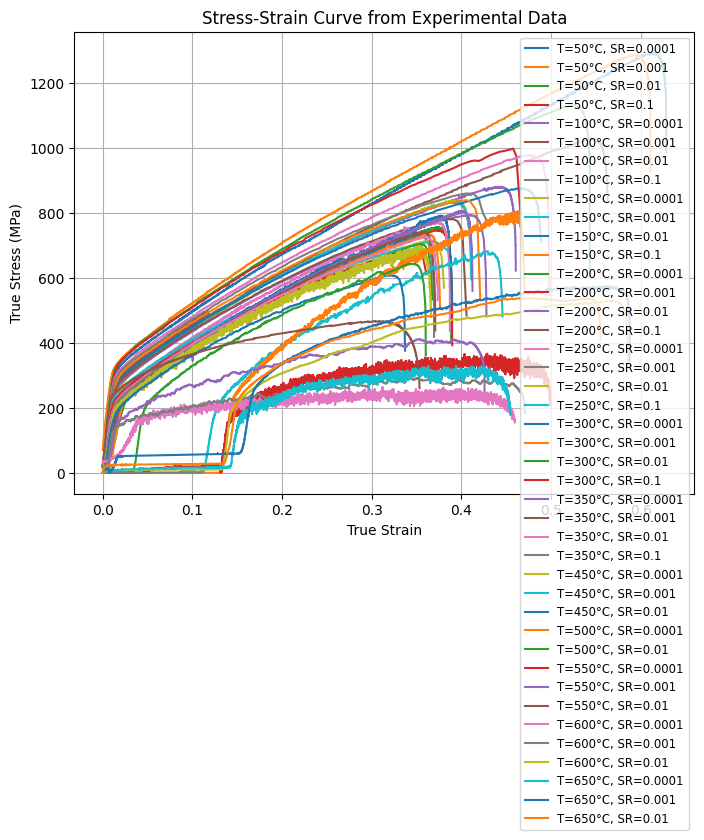

In [ ]:
raw_stress_strain(final_data)

## 6.0 Deployment

### 6.1 Load the saved model

In [ ]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out.squeeze()

model = LSTMRegressor(input_size=3, hidden_size=64, num_layers=1)

# Load the state dictionary, handling potential key mismatches
state_dict = torch.load('lstm_model_weights.pth')

# Filter out unexpected keys
compatible_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}

# Load the compatible state dictionary into the model
model.load_state_dict(compatible_state_dict, strict=False)

model.eval()

LSTMRegressor(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Engineering strain: 0.00025100231669413463
True strain: [0.         0.00025097 0.00050338 0.00075724 0.00101255]
Shape of Features: (1000, 3)
Shape of X_deploy: (990, 10, 3)
Predicted Stress: [[149.97327]
 [154.15704]
 [158.57999]
 [163.2453 ]
 [168.15308]]
Shape of Predicted Stress: (990, 1)
Shape of Features: (1000, 3)
Shape of X_deploy: (990, 10, 3)
Predicted Stress: [[130.09805]
 [133.80875]
 [137.70493]
 [141.79636]
 [146.09238]]
Shape of Predicted Stress: (990, 1)
Shape of Features: (1000, 3)
Shape of X_deploy: (990, 10, 3)
Predicted Stress: [[43.44263 ]
 [46.49802 ]
 [49.715153]
 [53.088566]
 [56.610386]]
Shape of Predicted Stress: (990, 1)
Shape of Features: (1000, 3)
Shape of X_deploy: (990, 10, 3)
Predicted Stress: [[38.962955]
 [41.910862]
 [45.01514 ]
 [48.27387 ]
 [51.685123]]
Shape of Predicted Stress: (990, 1)
Shape of Features: (1000, 3)
Shape of X_deploy: (990, 10, 3)
Predicted Stress: [[5.0825834]
 [5.2731657]
 [5.4937773]
 [5.7541227]
 [6.0650053]]
Shape of Predicted

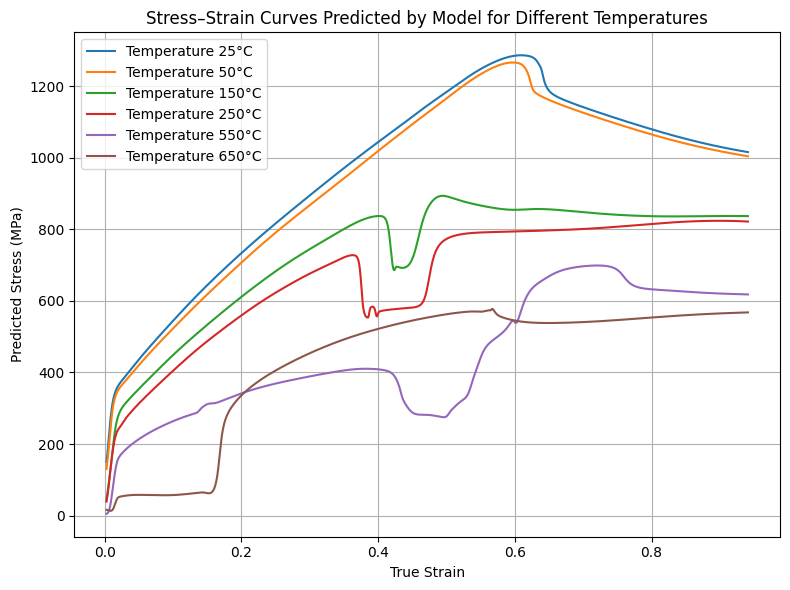

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


L0 = 6                  # Gauge length in cm
temperature_values = [25, 50, 150, 250, 550, 650]
seq_length = 10         # Sequence length expected by the LSTM model

# Time vector from 0 to 5 seconds with 1000 samples
t = np.linspace(0, 1.5, 1000)


# ---------------------------
# Generate Displacement and Compute Strain
# ---------------------------

x_t = (t**3 + 2 * t**2 + t)

# Engineering strain: eng_strain = x(t) / L0
eng_strain = (x_t / L0)
print(f"Engineering strain: {eng_strain[1]}")

# True strain: true_strain = ln(1 + eng_strain)
true_strain = np.log(1 + eng_strain)
true_strain = true_strain
print(f"True strain: {true_strain[:5]}")

# Calculate the numerical derivative of x with respect to t
dx_dt = np.gradient(x_t, t)  # derivative using central differences

# Engineering strain rate: d(epsilon)/dt = (dx/dt) / L0
strain_rate = 0.001

#strain_rate = (dx_dt / L0)
# print(f"Engineering strain rate: {strain_rate[:5]}")


# ---------------------------
# Create Sequences for LSTM Input
# ---------------------------
def create_sequences_from_deployment(features, seq_length):

    X_seq = []
    for i in range(len(features) - seq_length):
        X_seq.append(features[i : i + seq_length])
    return np.array(X_seq)


# ---------------------------
# Assemble the Feature Matrix using True Strain
# ---------------------------
plt.figure(figsize=(8, 6))

#Load model
model.load_state_dict(torch.load('lstm_model_weights.pth'))
for temperature in temperature_values:
  features = np.column_stack([
      np.full_like(true_strain, temperature),   # constant temperature column
      np.full_like(true_strain, strain_rate),   # strain rate column
      true_strain
  ])
  print(f"Shape of Features: {features.shape}")

  features_scaled = scaler.transform(features)

  # Generate sequences for deployment
  X_deploy = create_sequences_from_deployment(features_scaled, seq_length)
  print(f"Shape of X_deploy: {X_deploy.shape}")

  # Convert the sequences into a torch tensor
  X_deploy_tensor = torch.tensor(X_deploy, dtype=torch.float32)

  # ---------------------------
  # Use the LSTM to Predict Stress
  # ---------------------------
  model.eval()
  with torch.no_grad():

      predicted_stress = model(X_deploy_tensor).squeeze().cpu().numpy()
  predicted_stress = target_scaler.inverse_transform(predicted_stress.reshape(-1, 1))
  print(f"Predicted Stress: {predicted_stress[:5]}")
  print(f"Shape of Predicted Stress: {predicted_stress.shape}")

  # ---------------------------
  # Align True Strain for the Plot
  # ---------------------------
  true_strain_for_plot = true_strain[seq_length:]

  # ---------------------------
  # Plot the Stress-Strain Curve (Using True Strain)
  # ---------------------------
  # Plot
  plt.plot(true_strain_for_plot, predicted_stress, label=f'Temperature {temperature}°C')

plt.xlabel("True Strain")
plt.ylabel("Predicted Stress (MPa)")
plt.title("Stress–Strain Curves Predicted by Model for Different Temperatures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 7.0 Results and Discussion


### 7.1 Comparison of Fully-Connected Naive NN and LSTM Results






**Training and Validation**



The number of training epochs and folds were initially set to 20 and 4, respectively. These values were chosen as preliminary settings to reduce computational time, with the intention of increasing them later to enhance model accuracy and precision. However, analysis of the validation loss across folds revealed a consistent and meaningful trend. In the first fold, the validation loss starts at 0.0257 and sharply declines to 0.0036, despite minor fluctuations. In the second fold, the loss continues to decrease, ranging from a maximum of 0.0046 to a minimum of 0.0025. For the third and fourth folds, the validation loss stabilizes around 0.0020 with no significant variation.
This observation suggests that the maximum validation loss in the first fold is approximately one order of magnitude higher than in the subsequent folds, indicating that the model effectively learned during early training stages. Consequently, the validation loss converges to a consistent value near 0.002, which may be considered a global minimum for the current setup. Given this convergence, increasing the number of epochs or folds further might not improve performance but instead leads to unnecessary computational cost. Therefore, the initial settings for epochs and folds were maintained.


**Scatter plots for Predicted and Actual Stresses**


The predicted and actual stress values obtained from both the Naive Neural Network (NN) and the LSTM model are compared using scatter plots, where a red dashed line represents the ideal scenario in which predicted stress equals actual stress. This line serves as a visual reference to assess model accuracy. Ideally, all points would lie on this line; however, due to inherent prediction errors, a distribution around the line is expected. To enhance interpretability, the data is presented in standardized form.
Despite the consistently low error metrics, the possibility of overfitting was considered and examined using the test dataset. The Naive NN model yields a Mean Absolute Error (MAE) of 0.022014 and a Root Mean Squared Error (RMSE) of 0.206223. The relatively larger RMSE compared to the MAE suggests that while average prediction accuracy is high, there are a few instances of significant error, as RMSE disproportionately penalizes larger deviations.
In contrast, the LSTM model exhibits a slightly higher MAE of 0.033791 but a notably lower RMSE of 0.131262. This indicates that, although the LSTM’s average prediction error is slightly greater, its predictions are more consistent and less influenced by large outliers. Therefore, while the Naive NN shows better pointwise accuracy, the LSTM model demonstrates improved robustness and generalization.
However, the LSTM model encounters difficulties in predicting initial stress values, as evident from the greater scatter of data points at the lower end of the stress range. This may be attributed to the limited number of low-stress data points available for training. Nevertheless, given the strong performance of the model on the test set, the concern of overfitting was ultimately ruled out.





**Stress-Strain Curve for Predcited and Actual data**

The stress-strain graphs are generated to compare the predicted curves, represented by dotted lines or discrete points, from the Fully Connected Naive Neural Network (FC Naive NN) with the experimental data. Throughout the training, testing, and validation phases, true strain values were used in place of plastic strains. This choice was made because plastic strain values frequently include zeros, leading to discontinuities in the predicted flow stress and compromising the model’s reliability. In contrast, true strain values contain fewer zeros and encompass both elastic and plastic deformation, making them a more robust alternative.
The graphs are categorized into two groups based on temperature: Group 1 includes low temperatures (50 °C and 150 °C), while Group 2 covers high temperatures (550 °C and 650 °C). These specific temperatures were selected to provide a clear distinction between low and high thermal conditions; intermediate temperatures were omitted to maintain clarity and avoid overcomplicating the visualization. Both groups share the same strain rate range, from 0.0001 s⁻¹ to 0.01 s⁻¹.
The results show that at lower temperatures, the predicted stress-strain curves closely match the experimental data which indicates high prediction accuracy. However, at higher temperatures, the agreement deteriorates, which may be attributed to increased noise in the experimental data which reduces the precision of the model’s predictions.


**Deployment Results**

The deployment line graphs are generated for all temperatures except those used in testing. In this context, the stress-strain curves represent the relationship between the predicted stress and the strain which is modeled using a polynomial function. The general shape of the curves aligns with expected material behavior; an initial increase in stress with strain, followed by yielding and eventual fracture under continued loading. For the deployment analysis, testing is assumed to occur at room temperature, and Hooke’s law is applied to convert displacement into strain and strain rate.
From the graphs, a strong correlation between the predicted and actual peak stress and strain is observed at lower temperatures, with values reaching approximately 1300 MPa and 0.6, respectively. After this peak, the stress sharply drops that indicates the behavior of the actual curve. Although the deployment curves at low temperatures exhibit some fluctuations, they remain relatively clean. In contrast, high-temperature curves appear noisier and deviate from the typical shape of stress-strain behavior, likely due to increased data uncertainty.
Despite this, the predicted and actual values at the point of maximum stress, referred to as the ultimate tensile strength (UTS), and corresponding strain are generally consistent. For example, at 650 °C, both predicted and actual peak values are around 600 MPa and 0.6 strain. Similar trends are observed with the LSTM predictions, except at 550 °C, where the predicted peak stress and strain are nearly twice as high as those predicted by the Naive Neural Network.

